## Background and Objectives
It has been always important for the digital media company to study customer behaviour data regarding the product then develop personalized recommendation for the customer, which is beneficial for building loyal customer relationships and attracting new customers. In a specific case, based on the customers’ ratings and reviews of films, we can recommend them other films that they may also like. The dataset (ml-20m) we are going to explore in this project describes 5-star rating activity from 138493 users between January 09, 1995 and March 31, 2015 of MovieLens , a web-based movie recommendation system. For this dataset, we will focus on only using the explicit ratings from the user history and make predictions on their rating for unwatched films so we can distinguish the potential films that they would like, and we would like to avoid recommending only the popular films among the population. However, there are challenges when making predictions and such recommendations. For example, some users have limited history that the recommendations may have large bias. On the contrary, some users may have a long history of over 10 year period but their preferences change over time. 

## Data Analysis

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
import seaborn as sns
df = pd.read_csv('downloads/ml-20m/ratings.csv',sep = ',',usecols = ['userId','movieId','rating'])

The number unique of users is 138493
The number of unique items is 26744
The sparsity level is 99.5 %


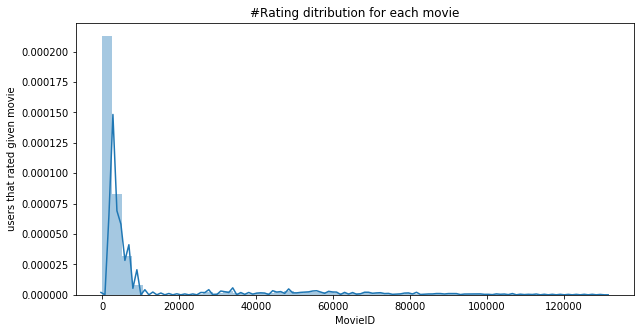

In [21]:
n_users = df['userId'].nunique()
n_items = df['movieId'].nunique()
sparsity = round(1.0-len(df)/float(n_users*n_items),3)
print('The number unique of users is',n_users)
print('The number of unique items is',n_items)
print('The sparsity level is',sparsity*100,'%')

fig, ax = plt.subplots(figsize=(10,5))
fig = sns.distplot(df['movieId'])
ax.set_ylabel('users that rated given movie')
ax.set_xlabel('MovieID')
ax.set_title('#Rating ditribution for each movie')
plt.show()

In [ ]:
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit

#
als = ALS(userCol="userId", itemCol="movieId", ratingCol="rating", coldStartStrategy="drop")
model = als.fit(training)

#grid search
paramGrid = ParamGridBuilder()\
    .addGrid(als.rank, [4,8,12]) \
    .addGrid(als.regParam, [0.1,1,10])\
    .addGrid(als.maxIter, [5,10,15])\
    .build()

tvs = TrainValidationSplit(estimator=als,
                           estimatorParamMaps=paramGrid,
                           evaluator=rmse,
                           # 80% of the data will be used for training, 20% for validation.
                           trainRatio=0.8)


# Evaluate the model by computing the RMSE on the test data
predictions = model.transform(test)
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating",
                                predictionCol="prediction")
rmse = evaluator.evaluate(predictions)
print("Root-mean-square error = " + str(rmse))

In [1]:
import os
import pyspark
from pyspark import SparkFiles
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.sql.functions import rand, col
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit

seed = 100
sc = SparkContext()
filePath = "downloads/ml-20m/ratings.csv"


# read dataset into spark RDD
sc.addFile(filePath)
sqlContext = SQLContext(sc)
df = sqlContext.read.csv(
    SparkFiles.get("ratings.csv"), 
    header=True, 
    inferSchema=True
)

sqlContext.registerDataFrameAsTable(df, "df")
df = sqlContext.sql('''
    SELECT 
        userId AS user, 
        movieId AS item,
        rating
    FROM df
''')


# adding uniform random numbers for train/validation/test set
df = df.withColumn('TrainTest', rand(seed=seed))

#save to json file
df.write.save("movielens.parquet")


In [1]:
from pyspark.context import SparkContext
from pyspark.sql.session import SparkSession
from pyspark.sql.functions import rand, col


sc = SparkContext('local')
spark = SparkSession(sc)
df = spark.read.load("movielens.parquet")
#df = df.sample(False,0.001)
dftrain = df.where(col('TrainTest') < 0.75).drop(*["TrainTest"])
dftest = df.where(col('TrainTest') >= 0.75).drop(*["TrainTest"])

In [2]:
import os
import math
import operator
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit
seed = 100

rmse_list = []
mae_list = []

ranks = [5, 10, 20]
ranks = [20]
regs = [0.05, 0.1, 1]
regs = [0.05]
rmse = RegressionEvaluator(metricName="rmse", labelCol="rating")
mae = RegressionEvaluator(metricName="mae", labelCol="rating")

for rank in ranks:
    for reg in regs:
        als = ALS(rank = rank,regParam = reg, nonnegative=True, checkpointInterval=3, coldStartStrategy="drop")
        
        paramGrid = ParamGridBuilder()\
            .addGrid(als.rank, [rank]) \
            .addGrid(als.regParam, [reg])\
            .build()

        tvs = TrainValidationSplit(
            estimator=als,
            evaluator=rmse,
            estimatorParamMaps=paramGrid,
            seed=seed,
            trainRatio=0.66, # this ratio makes train:0.5 valid:0.25 and test:0.25
            parallelism=6,
        )

        model = tvs.fit(dftrain)
        testPred = model.transform(dftest)
        error1 = rmse.evaluate(testPred)
        error2 = mae.evaluate(testPred)
        print('{} latent factors and regularization = {}: validation RMSE is {}，MAE is {}'.format(rank, reg, error1,error2))
        rmse_list.append(error1)
        mae_list.append(error2)

5 latent factors and regularization = 0.05: validation RMSE is 2.297567713549243，MAE is 1.9509435099507366
5 latent factors and regularization = 0.1: validation RMSE is 2.166218763871715，MAE is 1.8553269704862572
5 latent factors and regularization = 1: validation RMSE is 2.318847382404193，MAE is 2.080882850584687
10 latent factors and regularization = 0.05: validation RMSE is 2.231008172023235，MAE is 1.929255307221796
10 latent factors and regularization = 0.1: validation RMSE is 2.2210983136239744，MAE is 1.928803488263901
10 latent factors and regularization = 1: validation RMSE is 2.4294885784210356，MAE is 2.2011946725293337
20 latent factors and regularization = 0.05: validation RMSE is 2.1603872842932397，MAE is 1.8981339500764305
20 latent factors and regularization = 0.1: validation RMSE is 2.181622407182632，MAE is 1.927275746051699
20 latent factors and regularization = 1: validation RMSE is 2.4317256729957055，MAE is 2.2244741078284864


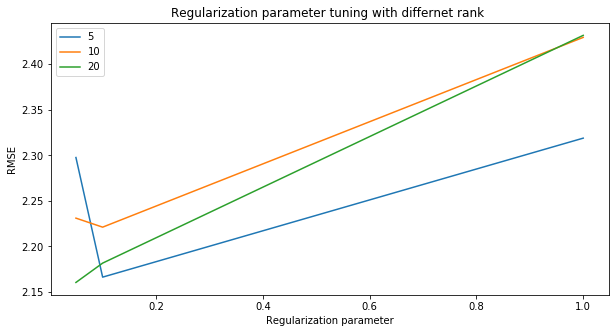

In [5]:
import matplotlib.pylab as plt
%matplotlib inline
fig, ax = plt.subplots(figsize=(10,5))
plt.plot(regs, rmse_list[0:3],regs,rmse_list[3:6], regs,rmse_list[6:9])
ax.set_ylabel('RMSE')
ax.set_xlabel('Regularization parameter')
ax.set_title('Regularization parameter tuning with differnet rank ')
plt.legend(['5', '10', '20'], loc = 'upper left', frameon=True)

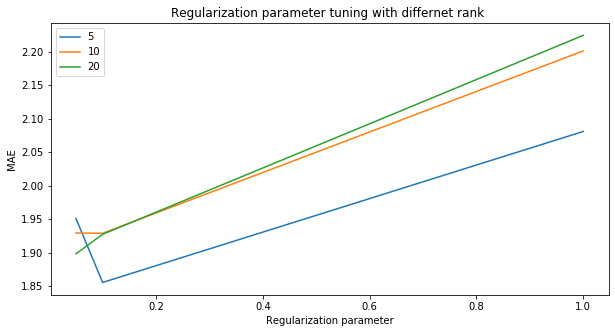

In [7]:
fig, ax = plt.subplots(figsize=(10,5))
plt.plot(regs, mae_list[0:3],regs,mae_list[3:6], regs,mae_list[6:9])
ax.set_ylabel('MAE')
ax.set_xlabel('Regularization parameter')
ax.set_title('Regularization parameter tuning with differnet rank ')
plt.legend(['5', '10', '20'], loc = 'upper left', frameon=True)

In [2]:
import os
import math
import operator
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit
seed = 100

rmse_list = []
mae_list = []

ranks = [20]
regs = [0.05]
rmse = RegressionEvaluator(metricName="rmse", labelCol="rating")
mae = RegressionEvaluator(metricName="mae", labelCol="rating")

for rank in ranks:
    for reg in regs:
        als = ALS(rank = rank,regParam = reg, nonnegative=True, checkpointInterval=3, coldStartStrategy="drop")
        
        paramGrid = ParamGridBuilder()\
            .addGrid(als.rank, [rank]) \
            .addGrid(als.regParam, [reg])\
            .build()

        tvs = TrainValidationSplit(
            estimator=als,
            evaluator=rmse,
            estimatorParamMaps=paramGrid,
            seed=seed,
            trainRatio=0.66, # this ratio makes train:0.5 valid:0.25 and test:0.25
            parallelism=6,
        )

        model = tvs.fit(dftrain)
        trainPred = model.transform(dftrain)
        error1 = rmse.evaluate(trainPred)
        error2 = mae.evaluate(trainPred)
        print('{} latent factors and regularization = {}: training RMSE is {}，MAE is {}'.format(rank, reg, error1,error2))

NameError: name 'trainPred' is not defined

In [3]:
model = tvs.fit(dftrain)
trainPred = model.transform(dftrain)
error1 = rmse.evaluate(trainPred)
error2 = mae.evaluate(trainPred)
print('{} latent factors and regularization = {}: training RMSE is {}，MAE is {}'.format(rank, reg, error1,error2))

20 latent factors and regularization = 0.05: training RMSE is 0.718184818499118，MAE is 0.5591820663966405


In [13]:

y = [np.mean(mae_list[0,3,6]),np.mean(mae_list[1,4,7]),np.mean(mae_list[6:9])]
plt.plot(ranks,y)
ax.set_ylabel('MAE')
ax.set_xlabel('#latent factors')
ax.set_title('Latent dimension tuning ')
plt.legend(['5', '10', '20'], loc = 'upper left', frameon=True)

TypeError: list indices must be integers or slices, not tuple